# MNIST: exploring the "confusion" range of failed classifications

 The purpose of this work is to explore such cases when a simple NN fails to classify digits correctly on MNIST dataset and to see if there is an identifiable pattern in prediction weights it produces in such cases that could signal that network is "confused" or unsure about which class to assign to a digit it "sees".
 
 Indeed, at the end of this notebook we see that when two or more neurons of final layer fire with weights values that are very close to each other, the chances are, we have an incorrect answer. 

In [246]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

In [247]:
#load MNIST data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


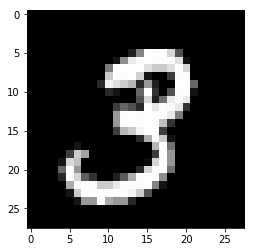

In [248]:
#quick sanity check
plt.imshow(mnist.train.images[1].reshape(28,28),cmap='gist_gray')

## Tensorflow

#### First, we are going to build a very simple neural net with just one layer using tensorflow

In [249]:
# set up tensorflow variables
x = tf.placeholder(tf.float32,shape=[None,784])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

# create the graph
y = tf.matmul(x,W) + b 
y_true = tf.placeholder(tf.float32,[None,10])

# final touches
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)

train = optimizer.minimize(cross_entropy)

### Train and save the net

Because I want to take a look at each failed case separately I am going to train the network on a full MNIST train set in one swoop and save it. In the following steps we will load our model and then iterattively show each trained example again to collect more information about the failed cases.

In [250]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for step in range(1000):
        
        batch_x , batch_y = mnist.train.next_batch(100)
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y})
    
    # collecting results | yes, we are showing train results to our network again, not test ones. 
    # This is because we want to see which ones are "wrong"
    pred = sess.run(y,feed_dict={x:mnist.train.images,y_true:mnist.train.labels})
    
    # a quick check to see how our simple net is doing when shown test data
    matches = tf.equal(tf.argmax(y,1),tf.argmax(y_true,1))
    acc = tf.reduce_mean(tf.cast(matches,tf.float32))
    print(sess.run(acc,feed_dict={x:mnist.test.images,y_true:mnist.test.labels})); # uncomment ; to see results during training

0.9151


In [251]:
# OK. here is how the table of all our prediction looks like:

pred = pd.DataFrame(pred)
pred.head()

,0,1,2,3,4,5,6,7,8,9
0,-3.802477,-2.165366,-0.155985,-0.026194,-0.346130,-0.265200,-4.092733,5.749965,-0.006910,5.111029
1,-0.223371,-9.008095,-1.332959,-4.271188,9.955893,-2.341348,4.163679,0.273117,-2.049577,4.833848
2,-2.084724,-4.304952,-2.745311,-0.386688,-0.639435,1.028533,-4.925027,7.403556,0.360574,6.293476
3,-2.391859,-9.035031,1.739315,-3.739660,4.983220,-2.224536,2.605922,0.197526,2.161737,5.703365
4,-3.274205,-1.121899,0.936674,-4.786599,6.744702,-3.184332,2.520035,0.887208,-0.131415,1.409831


#####  a side experiment - i am really curious to see how many neurons/classes have fired positively for a given case; this could be interresting in relation to detecting our "confusion" cases

In [255]:
pos = pred.apply(lambda x: [1 if y>0 else 0 for y in x], axis = 1)
pos.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,1,0,1,1,0,1
2,0,0,0,0,0,1,0,1,1,1
3,0,0,1,0,1,0,1,1,1,1
4,0,0,1,0,1,0,1,1,0,1


In [256]:
# now let's count them and put it back to our dataframe

pred['count'] = pos.T.sum()
pred.head()

,0,1,2,3,4,5,6,7,8,9,count
0,-3.802477,-2.165366,-0.155985,-0.026194,-0.346130,-0.265200,-4.092733,5.749965,-0.006910,5.111029,2
1,-0.223371,-9.008095,-1.332959,-4.271188,9.955893,-2.341348,4.163679,0.273117,-2.049577,4.833848,4
2,-2.084724,-4.304952,-2.745311,-0.386688,-0.639435,1.028533,-4.925027,7.403556,0.360574,6.293476,4
3,-2.391859,-9.035031,1.739315,-3.739660,4.983220,-2.224536,2.605922,0.197526,2.161737,5.703365,6
4,-3.274205,-1.121899,0.936674,-4.786599,6.744702,-3.184332,2.520035,0.887208,-0.131415,1.409831,5


In [257]:
# lets look at some stats on this

pred['count'].describe()

count    55000.000000
mean         4.965691
std          0.884709
min          2.000000
25%          4.000000
50%          5.000000
75%          6.000000
max          9.000000
Name: count, dtype: float64

so, what we see here is that on average out net fires positively for about 5 classes in a any given example 
what's interresting here is that a minimun of 2 classes always get activated positively and in some cases 8 classes get activated

OK. Now let's roll through all our predictions and extract info and weights about top predicted classes 

In [258]:
top = {}
top['Y'] = []
top['1_arg'] = []
top['1_weight'] = []
top['2_arg'] = []
top['2_weight'] = []
top['3_arg'] = []
top['3_weight'] = []
top['4_arg'] = []
top['4_weight'] = []


for i in range(pred.shape[0]):

    top['Y'].append(batch_y[i].argmax())

    # get first top prediction                 
    top['1_arg'].append(pred[i].argmax())
    top['1_weight'].append(pred[i][top['1_arg'][i]])

    #reset it in the list                
    pred[i][top['1_arg'][i]] = 0

    # now, get second top prediction                
    top['2_arg'].append(pred[i].argmax())
    top['2_weight'].append(pred[i][top['2_arg'][i]])     
    
    pred[i][top['2_arg'][i]] = 0
    
    top['3_arg'].append(pred[i].argmax())
    top['3_weight'].append(pred[i][top['3_arg'][i]]) 
         
    pred[i][top['3_arg'][i]] = 0
    
    top['4_arg'].append(pred[i].argmax())
    top['4_weight'].append(pred[i][top['4_arg'][i]])  


/home/playadust/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/home/playadust/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/playadust/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/home/playadust/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A v

KeyError: 10

#### Lets put all that into a pandas dataframe. It will be easier to manipulate and analyze results this way

In [ ]:
top = pd.DataFrame(top)
top.head()

In [ ]:
top['4_weight'].min()

In [ ]:
top['3_weight'].min()

In [ ]:
top['2_weight'].min()

In [ ]:
top['1_weight'].min()

In [ ]:
results = pd.DataFrame(top)
results['diff'] = abs(results['1_weight'] - results['2_weight'])
results['correct'] = results['Y']==results['1_arg']

results.head()

In [ ]:
correct = results[results['correct']==True]
correct.head()

In [ ]:
wrong = results[results['correct']==False]
wrong.head()

In [ ]:
# sns.kdeplot(results['diff'])
sns.kdeplot(correct['diff'], label="correct")
sns.kdeplot(wrong['diff'], label="wrong")
plt.legend();

In [ ]:
results['correct'].value_counts()

In [ ]:
1-(55000-(4464*(1-0.9684466123580933)))/55000